## Identifying Parts of Speech using the hidden markov model

In [33]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

NLTK Treebank uses regular expressions for tokenizing the text. It can be invoked using the word_tokenize.
``don't`` -> ``do n't`` and ``they'll`` -> ``they 'll``

In [34]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\80234\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

Downloading the dataset of parts of speech using the NLTK library

In [35]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\80234\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [36]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [37]:
# setting up the random seed, split the dataset into training and the test set
train_set, test_set = train_test_split(nltk_data, train_size=0.95, random_state=101)
print(f"train set length: {len(train_set)}, test set length: {len(test_set)}")

train set length: 3718, test set length: 196


In [38]:
# Lets put all the tupples inside a single list
train_tagged_words = [tup for sentence in train_set for tup in sentence]
test_tagged_words = [tup for sentence in test_set for tup in sentence]

In [39]:
for i, j in zip(train_tagged_words[:5], test_tagged_words[:5]):
    print(f"train tupple: {i}, test tupple {j}")

train tupple: ('Reliance', 'NOUN'), test tupple ('The', 'DET')
train tupple: ('confirmed', 'VERB'), test tupple ('company', 'NOUN')
train tupple: ('the', 'DET'), test tupple ('said', 'VERB')
train tupple: ('filing', 'NOUN'), test tupple ('0', 'X')
train tupple: ('but', 'CONJ'), test tupple ('it', 'PRON')


In [40]:
# Put all the words inside another list
tokens = [pair[0] for pair in train_tagged_words]

In [41]:
# Create the set, consisting of all the unique words, later it will be used for creating emission and transition matrix
V = set(tokens)
print(f"number of all words: {len(V)}")

number of all words: 12100


In [42]:
T = set([pair[1] for pair in train_tagged_words])
print(f"All tagging words are: {T}")

All tagging words are: {'ADV', 'X', 'ADP', 'PRON', 'NUM', 'VERB', 'DET', '.', 'NOUN', 'ADJ', 'CONJ', 'PRT'}


### Build the POS tagger using the Vanilla Viterbi

create the probability matrix for emission (between the hidden states and the observations) 
and transition states (probability of getting the "verb" tag if the previous tag is "Noun"). 
Using the probability matrix for both emission and the transition states, we can find the 
tag based on the maximum probability (given the present word and the tag of the previous word), 
we can find the most likely tag for the present word.

$$P_{state} = \max(P_{emission} x P_{transition})$$ 

In [43]:
# Create the numpy array of number of pos tags by total vocabulary
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [44]:
# computing the count of the occurance of the word with a known tag
# This function will be used for calculating the emission matrix

def word_given_tag(word, tag, train_bag = train_tagged_words):
    # count tags
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    
    # count times the word occured given the tag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag_list = len(w_given_tag_list)
    return (count_w_given_tag_list, count_tag)

# computing the counts of tag2 given tag1 occurs in the previous index
# function below will be used for calculating the transition matrix

def tag2_given_tag1(tag2, tag1, train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_tag1 = len([tag for tag in tags if tag == tag1])
    count_tag2_given_tag1 = 0
    for idx, tag in enumerate(tags[:-1]):
        if tag == tag1 and tags[idx+1] == tag2:
            count_tag2_given_tag1 += 1
    return (count_tag2_given_tag1, count_tag1)

In [45]:
# Computing the Transition probability, given the previous tag

tags_transition_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, tag1 in enumerate(list(T)):
    for j, tag2 in enumerate(list(T)):
        result = tag2_given_tag1(tag2, tag1)
        tags_transition_matrix[i, j] = result[0]/result[1] 

tags_transition_matrix[i, j] represents the probability of occurance of $T_{j}$ given $T_{i}$

In [46]:
tags_transition_df = pd.DataFrame(tags_transition_matrix, columns=list(T), index=list(T))
tags_transition_df

,ADV,X,ADP,PRON,NUM,VERB,DET,.,NOUN,ADJ,CONJ,PRT
ADV,0.080490,0.023186,0.118582,0.014906,0.030474,0.343491,0.069891,0.137131,0.031467,0.129182,0.006956,0.014243
X,0.024984,0.076384,0.142584,0.055538,0.002864,0.203851,0.054742,0.163590,0.062381,0.017187,0.010662,0.185232
ADP,0.014006,0.034427,0.016893,0.070031,0.062226,0.008340,0.324709,0.039025,0.320967,0.107024,0.000962,0.001390
PRON,0.034074,0.089969,0.022971,0.007657,0.006508,0.485452,0.009954,0.040965,0.210949,0.073124,0.005360,0.013017
NUM,0.002978,0.210542,0.036033,0.001489,0.184932,0.018761,0.003276,0.117332,0.350208,0.034247,0.013699,0.026504
VERB,0.081952,0.217506,0.092022,0.035786,0.022851,0.169249,0.134392,0.034934,0.110070,0.064988,0.005577,0.030674
DET,0.012438,0.045405,0.009540,0.003744,0.022220,0.039850,0.005676,0.017993,0.638087,0.204323,0.000483,0.000242
.,0.052324,0.026971,0.091342,0.066349,0.081003,0.089095,0.173335,0.093320,0.222242,0.043963,0.057538,0.002427
NOUN,0.017074,0.029175,0.176514,0.004607,0.009542,0.147667,0.012942,0.240604,0.263564,0.012248,0.042666,0.043397
ADJ,0.004778,0.021091,0.078267,0.000330,0.021256,0.011699,0.004943,0.063931,0.699621,0.066403,0.016971,0.010710


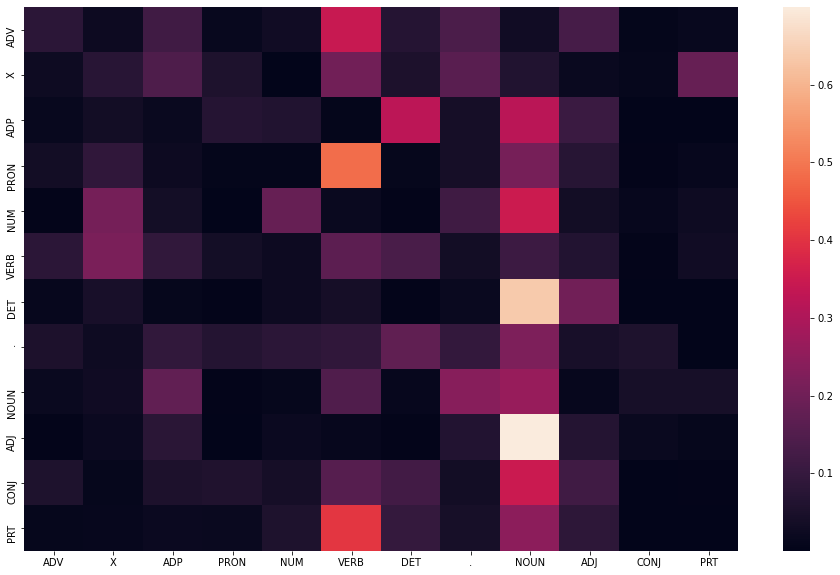

In [47]:
# Lets look at the heatmap of the matrix
plt.figure(figsize=(16, 10))
sns.heatmap(tags_transition_df)
plt.show()

Above heat map clearly shows correlation between the occurance of nouns, adjectives and the determinant

In [48]:
# Viterbi Heuristic
def viterbi_model(words, train_bag=train_tagged_words):
    state=[]
    T=list(set([pair[1] for pair in train_bag]))
    for idx, word in enumerate(words):
        # initialize list of probability column for a given observation
        p=[]
        for tag in T:
            if idx==0:
                transition_p=tags_transition_df.loc['.', tag]
            else:
                transition_p=tags_transition_df.loc[state[-1], tag]
            
            emission_count_word = word_given_tag(words[idx], tag)[0]
            emission_count_tag = word_given_tag(words[idx], tag)[1]
            emission_p = emission_count_word/emission_count_tag
            
            state_p = emission_p * transition_p
            p.append(state_p)
        p_max = max(p)
        state_with_max_p = T[p.index(p_max)]
        state.append(state_with_max_p)
    return list(zip(words, state))

In [55]:
# test the algorithm on a few sample of sentences of test dataset

test_run_base = [tup for sent in test_set[:10] for tup in sent]
test_tagged_words = [tup[0] for sent in test_set[:10] for tup in sent]

start = time.time()
tagged_seq = viterbi_model(test_tagged_words)
end = time.time()

print(f"time taken for algorithm: {end-start}")

time taken for algorithm: 54.0950722694397


In [56]:
# Calculate the accuracy of the model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9435483870967742


In [64]:
# Lets evaluate the algorithm using the precision, recall and F1 score
# Lets plot the heatmap of the confusion matrix
tags = tags_transition_df.columns
confusion_matrix = np.zeros((len(tags), len(tags)))
for i, tag1 in enumerate(tags):
    for j, tag2 in enumerate(tags):
        temp = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
        confusion_matrix[i, j] =     
        print(tag)

Index(['ADV', 'X', 'ADP', 'PRON', 'NUM', 'VERB', 'DET', '.', 'NOUN', 'ADJ',
       'CONJ', 'PRT'],
      dtype='object')
('1981', 'NUM')
('Prime', 'NOUN')
('world', 'NOUN')
('purpose', 'NOUN')
('built', 'VERB')
('far', 'ADV')
('glamorize', 'ADV')
('2.6', 'ADV')
('Minister', 'NOUN')
('*-1', 'X')
('dam', 'NOUN')
('Douglas', 'NOUN')
('investment', 'NOUN')
('take', 'VERB')
('The', 'DET')
('battery', 'NOUN')
('America', 'NOUN')
('same', 'ADJ')
('which', 'DET')
('Madison', 'NOUN')
('project', 'NOUN')
('problems', 'NOUN')
('not', 'ADV')
('yen', 'NOUN')
('$', '.')
('companies', 'NOUN')
('Bank', 'NOUN')
('U.S.', 'NOUN')
("''", '.')
('waiting', 'VERB')
('and', 'CONJ')
('Hungary', 'NOUN')
('corporate', 'ADJ')
('purchases', 'NOUN')
('entered', 'VERB')
('*-2', 'X')
('wants', 'VERB')
('This', 'DET')
('modify', 'VERB')
('Deere', 'ADV')
('assets', 'NOUN')
('chassis', 'NOUN')
('billion', 'NUM')
('*', 'X')
('insurance', 'NOUN')
('unit', 'NOUN')
('securities', 'NOUN')
('hurt', 'VERB')
('economic', 'ADJ')

i : ('The', 'DET'), j: ('The', 'DET')
i : ('company', 'NOUN'), j: ('company', 'NOUN')
i : ('said', 'VERB'), j: ('said', 'VERB')
i : ('0', 'X'), j: ('0', 'X')
i : ('it', 'PRON'), j: ('it', 'PRON')
i : ('is', 'VERB'), j: ('is', 'VERB')
i : ('in', 'ADP'), j: ('in', 'ADP')
i : ('the', 'DET'), j: ('the', 'DET')
i : ('process', 'NOUN'), j: ('process', 'NOUN')
i : ('of', 'ADP'), j: ('of', 'ADP')
i : ('*', 'X'), j: ('*', 'X')
i : ('phasing', 'VERB'), j: ('phasing', 'VERB')
i : ('out', 'PRT'), j: ('out', 'PRT')
i : ('John', 'NOUN'), j: ('John', 'NOUN')
i : ('Deere', 'ADV'), j: ('Deere', 'NOUN')
i : (',', '.'), j: (',', '.')
i : ('its', 'PRON'), j: ('its', 'PRON')
i : ('current', 'ADJ'), j: ('current', 'ADJ')
i : ('source', 'NOUN'), j: ('source', 'NOUN')
i : ('of', 'ADP'), j: ('of', 'ADP')
i : ('production', 'NOUN'), j: ('production', 'NOUN')
i : ('for', 'ADP'), j: ('for', 'ADP')
i : ('midsized', 'VERB'), j: ('midsized', 'ADJ')
i : ('motor', 'NOUN'), j: ('motor', 'NOUN')
i : ('home', 'NOUN'), j: